# 08_TopicLDA_Bayes
## Ray Hossain

## Setup

!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm
!python -m spacy info
-- Upgrade gensim in case.
!pip install --upgrade numpy
!pip install -U gensim==4.*

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import spacy

from gensim import models, corpora
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

In [2]:
data = pd.read_csv("Processed_Data/50_textscored_long.csv")

In [3]:
valid_mask = data['text_clean'].notna()


In [4]:
valid_mask.head()

0    True
1    True
2    True
3    True
4    True
Name: text_clean, dtype: bool

## SpaCy

In [5]:
# Load the German model
nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])

def improved_filter(tokenized_doc):
    return [t.lemma_ for t in tokenized_doc if
            t.is_alpha and \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.pos_ in ['NOUN', 'VERB', 'ADJ']]

## Topic LDA

In [6]:
NUM_PROCESS = 4

In [7]:
NUM_TOPICS = 10

In [8]:
# We'll need to retokenize everything and rebuild the BOWs. Because we're now
# using the POS tagger, this will take longer. The "w_pos" in the variable 
# names below just means "with part-of-speech".
tokenized_articles_w_pos = list(map(
    improved_filter, 
    nlp.pipe(data.loc[valid_mask, 'text_clean'].astype(str), n_process=NUM_PROCESS)
))

# 3. Create corpus and filter
dictionary_w_pos = corpora.Dictionary(tokenized_articles_w_pos)


### Trimming low & high frequency cells

In [9]:
len(dictionary_w_pos)

60803

The filtering is a bit idiosyncratic. The lower bound is an *absolute* number, and the upper bound is a *percentage*. Here, we're saying filter out words which occur in fewer than N documents and more than M% of the documents.

In [10]:
dictionary_w_pos.filter_extremes(no_below=10, no_above=0.25)

In [11]:
len(dictionary_w_pos)

14281

In [12]:
# Rebuild bag of words.
corpus_bow_w_pos_filtered = [dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos]

In [13]:
lda_model = models.ldamodel.LdaModel(
    corpus=corpus_bow_w_pos_filtered,
    id2word=dictionary_w_pos,
    num_topics=NUM_TOPICS,
    passes=10,
    alpha='auto',
    eta='auto',
    random_state=42
)


c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\gensim\models\ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [14]:
lda_model.print_topics()

[(0,
  '0.082*"Bewertung" + 0.049*"September" + 0.041*"Wahl" + 0.036*"deutsch" + 0.029*"Chef" + 0.027*"verlieren" + 0.017*"Geldanlage" + 0.017*"gruen" + 0.016*"neu" + 0.016*"wertpapi"'),
 (1,
  '0.097*"Fussball" + 0.043*"Ticker" + 0.038*"Frau" + 0.029*"Who" + 0.025*"koeln" + 0.019*"warnen" + 0.018*"spielen" + 0.017*"wissen" + 0.014*"stellen" + 0.013*"muenchen"'),
 (2,
  '0.037*"Partei" + 0.035*"Show" + 0.028*"Bericht" + 0.022*"Kind" + 0.022*"Stadt" + 0.021*"schulz" + 0.020*"Auto" + 0.019*"Kandidat" + 0.016*"Russland" + 0.016*"Familie"'),
 (3,
  '0.099*"Politik" + 0.046*"Inland" + 0.041*"Euro" + 0.026*"sterben" + 0.024*"Wahlkampf" + 0.023*"Geld" + 0.023*"Wirtschaft" + 0.021*"drohen" + 0.016*"sendung" + 0.013*"Ergebnis"'),
 (4,
  '0.210*"Sendung" + 0.028*"stehen" + 0.024*"dahoam" + 0.024*"Sport" + 0.020*"Kommentar" + 0.019*"auto" + 0.019*"gutschrift" + 0.017*"Frage" + 0.016*"stark" + 0.015*"Regionalsport"'),
 (5,
  '0.145*"Ausland" + 0.040*"Umfrage" + 0.039*"Erdbeben" + 0.029*"erdbeben" 

In [15]:
print(lda_model.alpha)
print(lda_model.eta)

[0.4880217  0.58327866 0.41811123 0.4871111  0.3257642  0.4638559
 0.4432578  0.34863454 0.35818267 0.39778164]
[0.07892876 0.076275   0.06882113 ... 0.07016492 0.07059152 0.06953669]


Looking at distributions


Function

### Evaluation/Coherence

In [16]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_articles_w_pos, dictionary=dictionary_w_pos, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -15.168992798287372


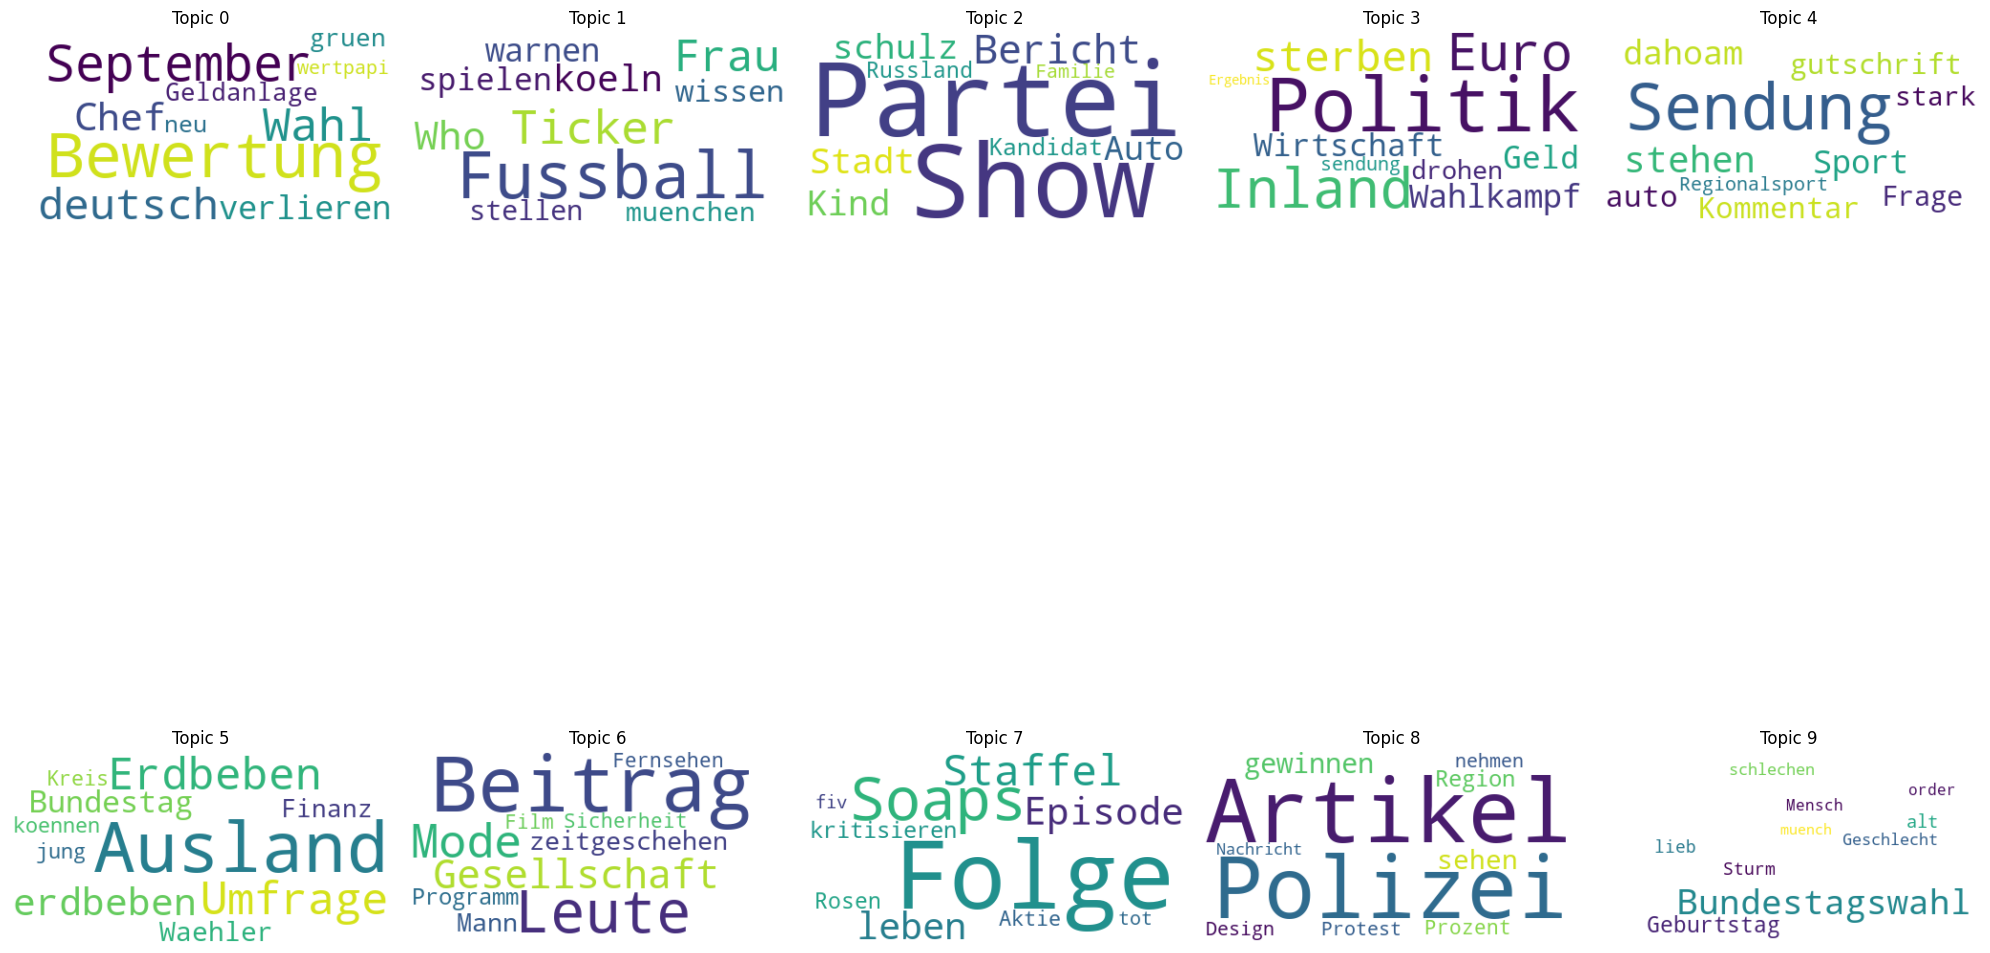

In [17]:
# For a larger visualization
def render_word_cloud(model, rows, cols, max_words):
    word_cloud = WordCloud(background_color='white', max_words=max_words, prefer_horizontal=1.0)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Increased figure size
    
    for i, ax in enumerate(axes.flatten()):
        if i < model.num_topics:  # Only process valid topic indices
            fig.add_subplot(ax)
            topic_words = dict(model.show_topic(i))
            word_cloud.generate_from_frequencies(topic_words)
            plt.gca().imshow(word_cloud, interpolation='bilinear')
            plt.gca().set_title('Topic {id}'.format(id=i))
            plt.gca().axis('off')
    
    plt.axis('off')
    plt.tight_layout()  # Improves spacing between subplots
    plt.show()

# Visualize all 20 topics
render_word_cloud(lda_model, 2, 5, 10)

### Visualization in English 
 

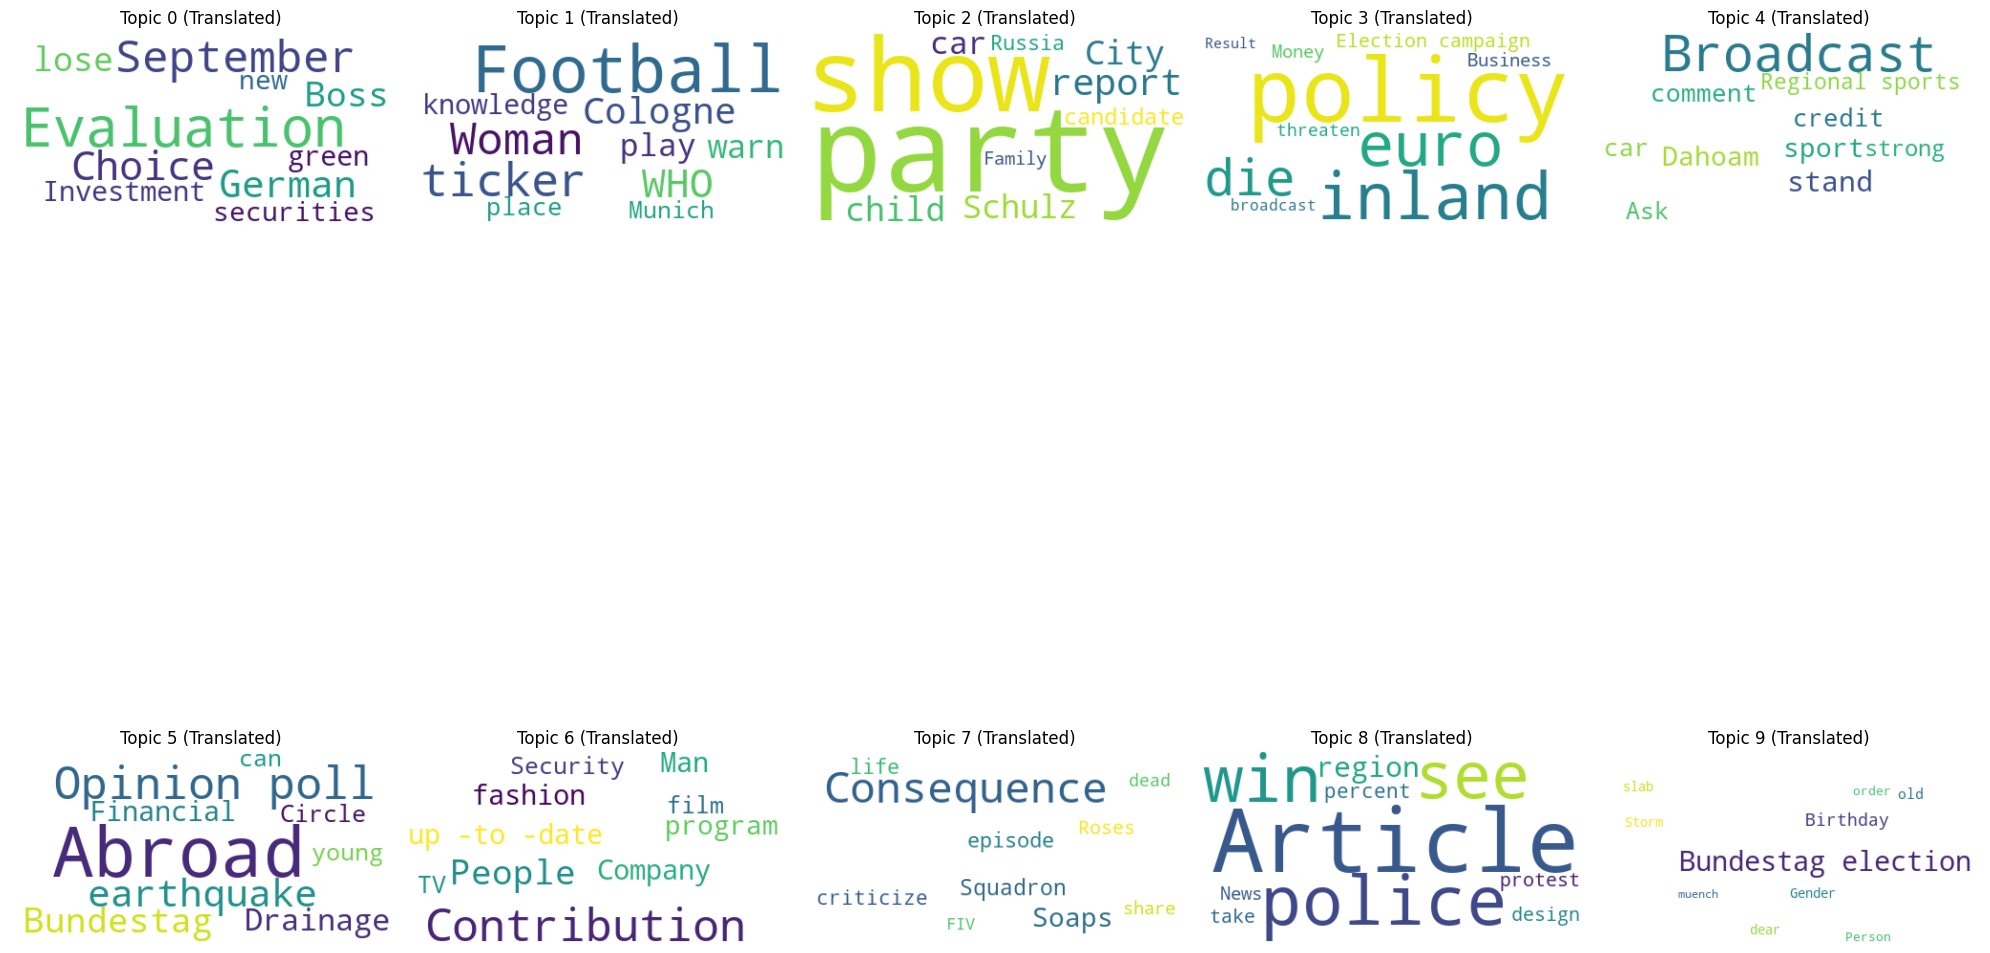

In [18]:
from deep_translator import GoogleTranslator
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def render_word_cloud_with_translation(model, rows, cols, max_words):
    translator = GoogleTranslator(source='de', target='en')  # German to English
    word_cloud = WordCloud(background_color='white', max_words=max_words, prefer_horizontal=1.0)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    
    for i, ax in enumerate(axes.flatten()):
        if i < model.num_topics:
            fig.add_subplot(ax)
            topic_words = dict(model.show_topic(i))
            
            # Translate the words to English
            translated_words = {}
            for word, weight in topic_words.items():
                try:
                    translated = translator.translate(word)
                    translated_words[translated] = weight
                except Exception as e:
                    print(f"Failed to translate '{word}': {e}")
                    translated_words[word] = weight  # Fallback to original
            
            word_cloud.generate_from_frequencies(translated_words)
            plt.gca().imshow(word_cloud, interpolation='bilinear')
            plt.gca().set_title(f'Topic {i} (Translated)')
            plt.gca().axis('off')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize all topics with translation
render_word_cloud_with_translation(lda_model, 2, 5, 10)

This is what 15 Topics looked like: 

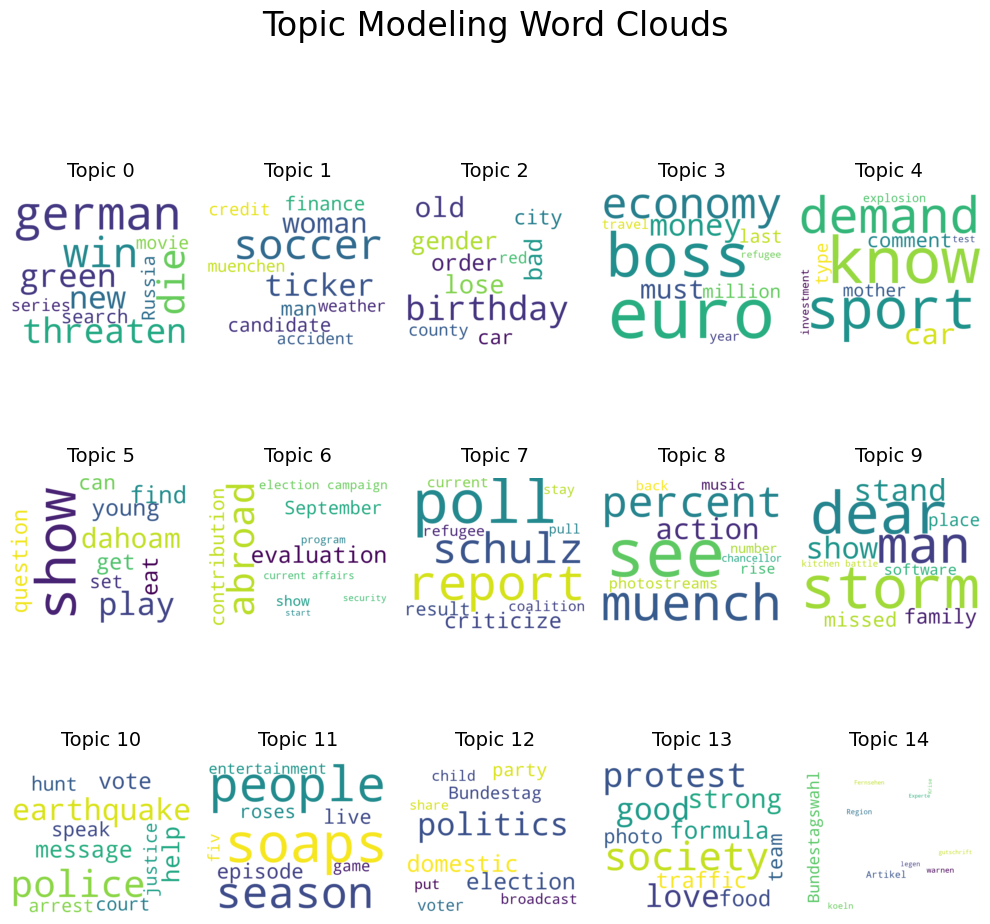

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

def parse_topic_string(topic_str):
    """Parse topic string into word-weight dictionary, handling smart quotes"""
    pattern = r'(\d+\.\d+)\*[“"]([^”"]+)[”"]'
    matches = re.findall(pattern, topic_str)
    return {word: float(weight) for weight, word in matches}

# Updated topic data with mixed German/English terms
topics = [
    (0, '0.088*“german” + 0.068*“win” + 0.054*“die” + 0.047*“threaten” + 0.041*“green” + 0.039*“new” + 0.032*“search” + 0.030*“Russia” + 0.029*“movie” + 0.025*“series”'),
    (1, '0.228*“soccer” + 0.105*“ticker” + 0.088*“woman” + 0.036*“man” + 0.033*“candidate” + 0.033*“finance” + 0.026*“credit” + 0.024*“weather” + 0.024*“muenchen” + 0.024*“accident”'),
    (2, '0.142*“birthday” + 0.090*“old” + 0.074*“lose” + 0.068*“gender” + 0.066*“bad” + 0.058*“order” + 0.047*“city” + 0.046*“car” + 0.030*“county” + 0.027*“red”'),
    (3, '0.122*“euro” + 0.089*“boss” + 0.068*“economy” + 0.054*“money” + 0.040*“must” + 0.036*“million” + 0.034*“last” + 0.032*“travel” + 0.029*“year” + 0.026*“refugee”'),
    (4, '0.079*“know” + 0.061*“sport” + 0.056*“demand” + 0.052*“car” + 0.052*“comment” + 0.040*“type” + 0.040*“mother” + 0.035*“explosion” + 0.031*“investment” + 0.023*“test”'),
    (5, '0.360*“show” + 0.057*“play” + 0.042*“dahoam” + 0.030*“find” + 0.028*“young” + 0.026*“get” + 0.026*“eat” + 0.025*“question” + 0.023*“can” + 0.018*“set”'),
    (6, '0.194*“abroad” + 0.141*“evaluation” + 0.099*“contribution” + 0.088*“September” + 0.051*“show” + 0.038*“election campaign” + 0.027*“program” + 0.026*“current affairs” + 0.020*“security” + 0.018*“start”'),
    (7, '0.111*“poll” + 0.069*“report” + 0.049*“schulz” + 0.045*“criticize” + 0.035*“result” + 0.029*“refugee” + 0.028*“current” + 0.026*“coalition” + 0.024*“stay” + 0.023*“pull”'),
    (8, '0.111*“see” + 0.068*“muench” + 0.055*“percent” + 0.044*“action” + 0.042*“photostreams” + 0.041*“music” + 0.039*“rise” + 0.034*“back” + 0.033*“number” + 0.028*“chancellor”'),
    (9, '0.081*“storm” + 0.078*“dear” + 0.060*“man” + 0.042*“stand” + 0.040*“show” + 0.036*“family” + 0.035*“missed” + 0.032*“place” + 0.032*“software” + 0.030*“kitchen battle”'),
    (10, '0.126*“police” + 0.083*“earthquake” + 0.047*“help” + 0.045*“message” + 0.043*“vote” + 0.032*“speak” + 0.031*“hunt” + 0.027*“court” + 0.027*“arrest” + 0.025*“justice”'),
    (11, '0.324*“episode” + 0.081*“soaps” + 0.064*“people” + 0.051*“season” + 0.047*“episode” + 0.044*“live” + 0.038*“roses” + 0.027*“fiv” + 0.025*“game” + 0.024*“entertainment”'),
    (12, '0.189*“politics” + 0.086*“domestic” + 0.083*“election” + 0.049*“party” + 0.043*“Bundestag” + 0.037*“voter” + 0.032*“child” + 0.031*“broadcast” + 0.031*“put” + 0.027*“share”'),
    (13, '0.087*“society” + 0.065*“protest” + 0.053*“love” + 0.052*“good” + 0.045*“strong” + 0.037*“formula” + 0.031*“traffic” + 0.031*“food” + 0.026*“team” + 0.025*“photo”'),
    (14, '0.325*“Bundestagswahl” + 0.067*“Artikel” + 0.056*“koeln” + 0.044*“warnen” + 0.037*“Region” + 0.030*“legen” + 0.025*“Fernsehen” + 0.024*“gutschrift” + 0.019*“Experte” + 0.019*“Krise”')
]

# Set up visualization parameters
rows, cols = 3, 5  # 15 topics in 5x3 grid
max_words = 15

def visualize_topics(topics_data, rows, cols, max_words):
    """Create word clouds for each topic in a grid layout"""
    wordcloud = WordCloud(
        width=600,
        height=500,
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        prefer_horizontal=0.9,
        min_font_size=10
    )
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    fig.suptitle('Topic Modeling Word Clouds', fontsize=24, y=1.02)
    
    for idx, (topic_num, topic_str) in enumerate(topics_data):
        ax = axes.flatten()[idx]
        
        # Parse topic string and create word cloud
        word_freq = parse_topic_string(topic_str)
        wordcloud.generate_from_frequencies(word_freq)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {topic_num}', fontsize=14, pad=12)
        ax.axis('off')
    
    # Hide empty subplots
    for j in range(len(topics_data), rows * cols):
        axes.flatten()[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate the visualization
visualize_topics(topics, rows, cols, max_words)

I have decided to keep the 10 topics model:

0: Politics
1: Soccer
2: Demographics
3: Society/Contribution
4: Entertainment
5: Domestic 
6: Elections
7: Entertainment
8: Travel
9: General

In [20]:
topic_mapping = {
    0: 'Economy',
    1: 'Sports 1',
    2: 'Elections',
    3: 'Politics',
    4: 'Sports 2',
    5: 'Current Events',
    6: 'Entertainment 1',
    7: 'Entertainment 2',
    8: 'Law and Order',
    9: 'General'
}

In [21]:
import numpy as np

In [22]:
# --- Define helper functions ---
def get_dominant_topic(lda_model, bow):
    """Returns the topic ID with the highest probability for a document."""
    topic_dist = lda_model[bow]
    if not topic_dist:  # handle empty documents
        return np.nan  # or -1 if you prefer numeric placeholder
    return max(topic_dist, key=lambda x: x[1])[0]  # returns topic with highest probability

In [23]:
# 5. Initialize topic columns
data['dominant_topic'] = np.nan  # or -1 for numeric placeholder
data['topic_label'] = "Unassigned"

# 6. Assign topics to valid rows only
valid_topics = [get_dominant_topic(lda_model, bow) for bow in corpus_bow_w_pos_filtered]
data.loc[valid_mask, 'dominant_topic'] = valid_topics
data.loc[valid_mask, 'topic_label'] = data.loc[valid_mask, 'dominant_topic'].map(topic_mapping)

In [24]:
# Get the top N words for each topic
def get_topic_terms(topic_id, topn=10):
    if np.isnan(topic_id):  # Handle NaN/NA dominant_topic values
        return []
    return [word for word, prob in lda_model.show_topic(int(topic_id), topn=topn)]

# Create a dictionary of topic terms (including handling for missing topics)
topic_terms = {
    i: [word for word, prob in lda_model.show_topic(i, topn=5)] 
    for i in range(lda_model.num_topics)
}

# Map to DataFrame - handles NaN/NA values via the function
data['topic_terms'] = data['dominant_topic'].apply(get_topic_terms)

In [25]:
# Add dominant topic probability column (aligned with valid documents only)
data['dominant_topic_prob'] = np.nan  # Initialize with NA values
valid_probs = [max(lda_model[bow], key=lambda x: x[1])[1] if bow else np.nan 
             for bow in corpus_bow_w_pos_filtered]
data.loc[valid_mask, 'dominant_topic_prob'] = valid_probs

In [26]:
#data.head()

In [27]:
#data[data['text_clean'].isna()]

In [28]:
data['topic_label'].value_counts()

topic_label
Sports 1           127208
Economy             54282
Politics            49494
Entertainment 1     40383
Current Events      37076
Elections           29342
General             27019
Entertainment 2     24262
Law and Order       22950
Sports 2            22262
Unassigned          18577
Name: count, dtype: int64

In [29]:
data['dominant_topic_prob'].value_counts()

dominant_topic_prob
0.280018    6515
0.271594    4939
0.271594    3253
0.297942    2396
0.280018    2388
            ... 
0.208492       1
0.208492       1
0.208492       1
0.238873       1
0.398128       1
Name: count, Length: 166660, dtype: int64

In [30]:
data.to_csv('Processed_Data/80_TopicLDA_Long.csv', index= False)

## Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     14355
           2       0.28      0.83      0.42     23294
           3       0.00      0.00      0.00     10419
           4       0.24      0.33      0.28      5961
           5       0.29      0.12      0.16     12052
           6       0.00      0.00      0.00     12686
           7       0.24      0.17      0.20     11804

    accuracy                           0.27     90571
   macro avg       0.15      0.21      0.15     90571
weighted avg       0.16      0.27      0.17     90571



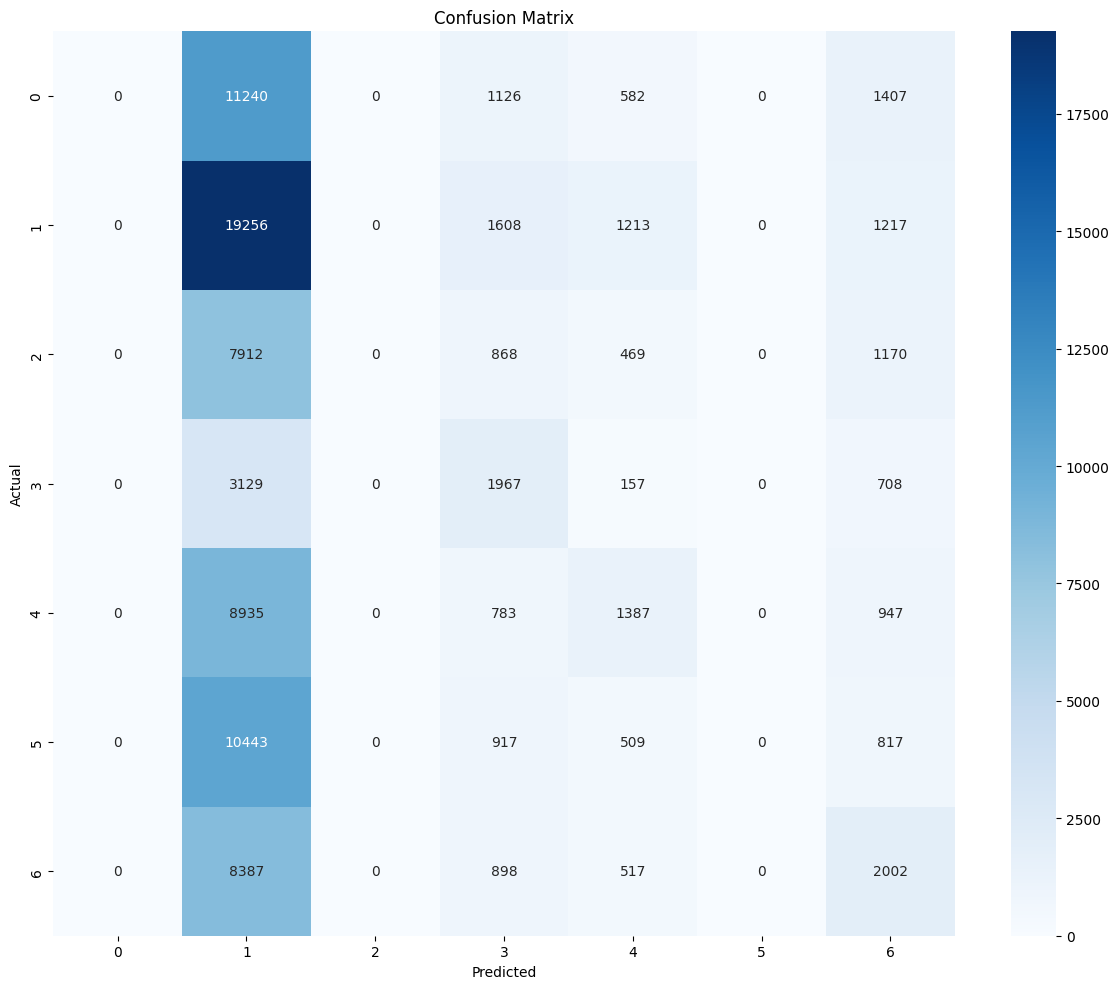


Topic Effects on Voting:
                  Class_1   Class_2   Class_3   Class_4   Class_5   Class_6  \
Current Events   0.107141  0.074163  0.087915  0.048042  0.074371  0.102057   
Economy          0.091522  0.181710  0.103747  0.067075  0.101560  0.118272   
Elections        0.072490  0.058978  0.063855  0.052193  0.058111  0.064859   
Entertainment 1  0.075188  0.069162  0.080023  0.324683  0.060890  0.077331   
Entertainment 2  0.040833  0.054085  0.043370  0.025991  0.115745  0.038242   
General          0.045552  0.088671  0.049319  0.031190  0.047534  0.060013   
Law and Order    0.052447  0.054267  0.049511  0.043012  0.043054  0.055777   
Politics         0.118738  0.097675  0.121306  0.074453  0.100046  0.143884   
Sports 1         0.301346  0.270295  0.286653  0.213549  0.319611  0.277386   
Sports 2         0.056261  0.033578  0.057571  0.065356  0.026836  0.042537   
Unassigned       0.038482  0.017417  0.056731  0.054456  0.052242  0.019643   

                  Class_7

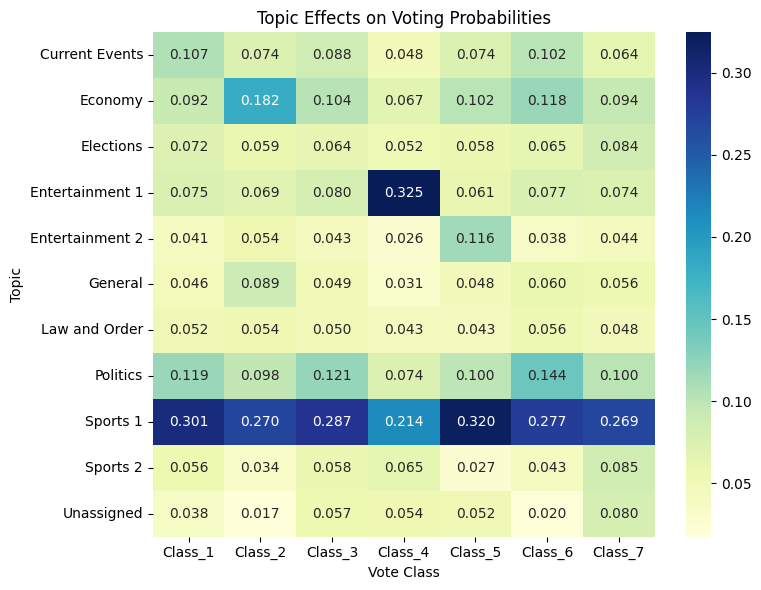

In [31]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Encode topics
label_encoder = LabelEncoder()
X = label_encoder.fit_transform(data['topic_label']).reshape(-1, 1)
y = data['secondvote']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)

# Evaluation with zero_division parameter
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# 3x3 Confusion Matrix
plt.figure(figsize=(12,10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(7),
            yticklabels=range(7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Previous code remains the same until after the confusion matrix...

# Topic effects analysis (corrected)
log_probs = nb_model.feature_log_prob_  # Shape: [n_features][n_classes][n_categories]
topic_effects = np.exp(log_probs[0])    # Get first (only) feature's probabilities

# Create DataFrame
topic_effects_df = pd.DataFrame(
    topic_effects.T,
    columns=[f"Class_{i}" for i in nb_model.classes_],
    index=label_encoder.classes_
)

print("\nTopic Effects on Voting:")
print(topic_effects_df)

# Visualization
plt.figure(figsize=(8,6))
sns.heatmap(topic_effects_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Topic Effects on Voting Probabilities')
plt.ylabel('Topic')
plt.xlabel('Vote Class')
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11804
           1       0.46      0.39      0.42     37460
           2       0.49      0.71      0.58     41307

    accuracy                           0.48     90571
   macro avg       0.32      0.36      0.33     90571
weighted avg       0.42      0.48      0.44     90571



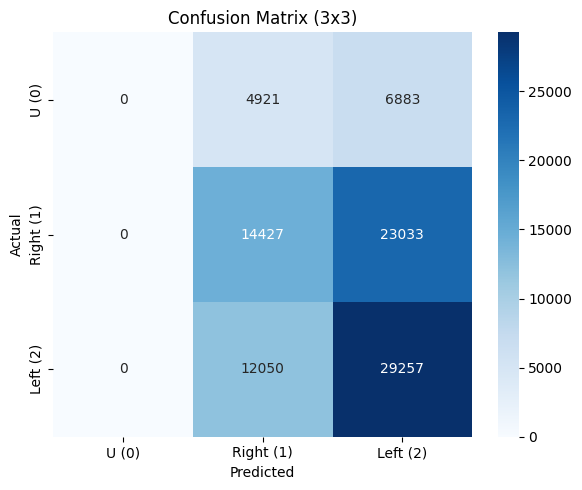


Topic Effects on Voting:
                  Class_0   Class_1   Class_2
Current Events   0.064939  0.100126  0.070353
Economy          0.093184  0.103923  0.141821
Elections        0.083106  0.066886  0.058002
Entertainment 1  0.074255  0.077117  0.103639
Entertainment 2  0.044803  0.040567  0.067751
General          0.055580  0.051738  0.068344
Law and Order    0.049927  0.053159  0.049426
Politics         0.100531  0.127213  0.095039
Sports 1         0.267547  0.290228  0.276415
Sports 2         0.084503  0.051711  0.036154
Unassigned       0.081624  0.037330  0.033056


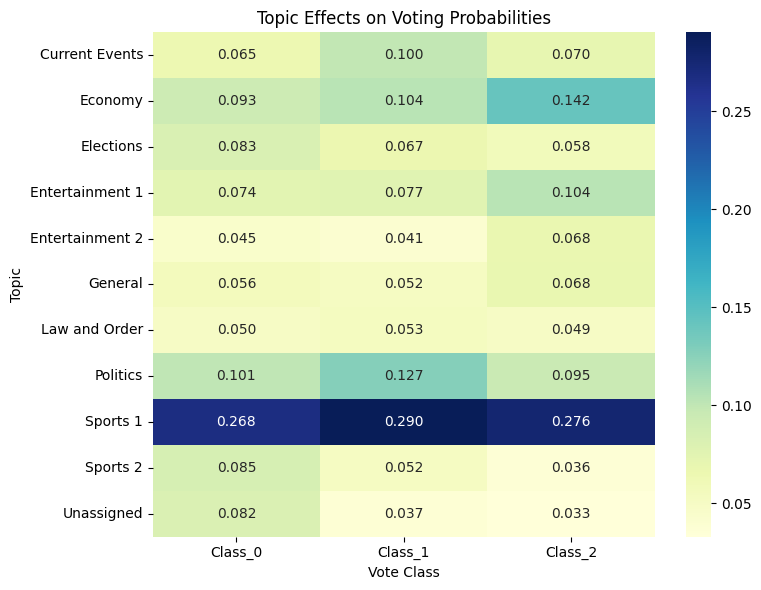

In [32]:

# Load and prepare data
data = pd.read_csv('Processed_Data/80_TopicLDA_Long.csv')
data['left_right'] = data['left_right'].map({0:0, 1:1, -1:2})  # Map to 0,1,2

# Encode topics
label_encoder = LabelEncoder()
X = label_encoder.fit_transform(data['topic_label']).reshape(-1, 1)
y = data['left_right']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)

# Evaluation with zero_division parameter
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# 3x3 Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['U (0)', 'Right (1)', 'Left (2)'],
            yticklabels=['U (0)', 'Right (1)', 'Left (2)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (3x3)')
plt.tight_layout()
plt.show()

# Previous code remains the same until after the confusion matrix...

# Topic effects analysis (corrected)
log_probs = nb_model.feature_log_prob_  # Shape: [n_features][n_classes][n_categories]
topic_effects = np.exp(log_probs[0])    # Get first (only) feature's probabilities

# Create DataFrame
topic_effects_df = pd.DataFrame(
    topic_effects.T,
    columns=[f"Class_{i}" for i in nb_model.classes_],
    index=label_encoder.classes_
)

print("\nTopic Effects on Voting:")
print(topic_effects_df)

# Visualization
plt.figure(figsize=(8,6))
sns.heatmap(topic_effects_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Topic Effects on Voting Probabilities')
plt.ylabel('Topic')
plt.xlabel('Vote Class')
plt.tight_layout()
plt.show()